In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


/home/sh/github/FoodNutritionEstimation


In [2]:
import math
import os
import random
import re
import sys
import time
sys.path.append('detection')
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from dataset import FoodDataset
from configs import *

from mrcnn import utils, visualize
import mrcnn.model as modellib
from mrcnn.model import log

# %matplotlib inline
inter_num = 0
np.set_printoptions(threshold=np.inf)


Using TensorFlow backend.


In [3]:
FEEDER_DIR = 'detection/__feeder__'
# Directory to save logs and trained model
MODEL_DIR = 'detection/__logs__'
# Local path to trained weights file
COCO_MODEL_PATH = 'data/mask_rcnn_coco.h5'
# Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_MODEL_PATH):
#     utils.download_trained_weights(COCO_MODEL_PATH)
config = BaseConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                43
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

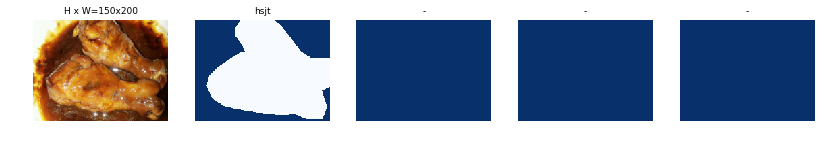

In [4]:
dataset_train = FoodDataset(FEEDER_DIR, train=True)
dataset_val = FoodDataset(FEEDER_DIR, train=False)
# Display some images of the food dataset
dataset_train.display(1)


In [5]:


def train(epoch_stage1=2, epoch_stage2=1):
    # Create model in training mode
    model = modellib.MaskRCNN(mode="training", config=config,
                              model_dir=MODEL_DIR)

    # Which weights to start with?
    init_with = "coco"  # imagenet, coco, or last

    if init_with == "imagenet":
        model.load_weights(model.get_imagenet_weights(), by_name=True)
    elif init_with == "coco":
        # Load weights trained on MS COCO, but skip layers that
        # are different due to the different number of classes
        # See README for instructions to download the COCO weights
        model.load_weights(COCO_MODEL_PATH, by_name=True,
                           exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                    "mrcnn_bbox", "mrcnn_mask"])
    elif init_with == "last":
        # Load the last model you trained and continue training
        model.load_weights(model.find_last(), by_name=True)

    # Fine tune all layers
    # Passing layers="all" trains all layers. You can also
    # pass a regular expression to select which layers to
    # train by name pattern.
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE / 10,
                epochs=epoch_stage1,
                layers="all")

    # Train the head branches
    # Passing layers="heads" freezes all layers except the head
    # layers. You can also pass a regular expression to select
    # which layers to train by name pattern.
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=epoch_stage2,
                layers='heads')
# Test training for 1 epoch
# train(epoch_stage1=1)



In [6]:
inference_config = InferenceConfig()
# Recreate the model in inference mode
model = modellib.MaskRCNN(
    mode="inference", config=inference_config, model_dir=f'{MODEL_DIR}')


Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 43)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


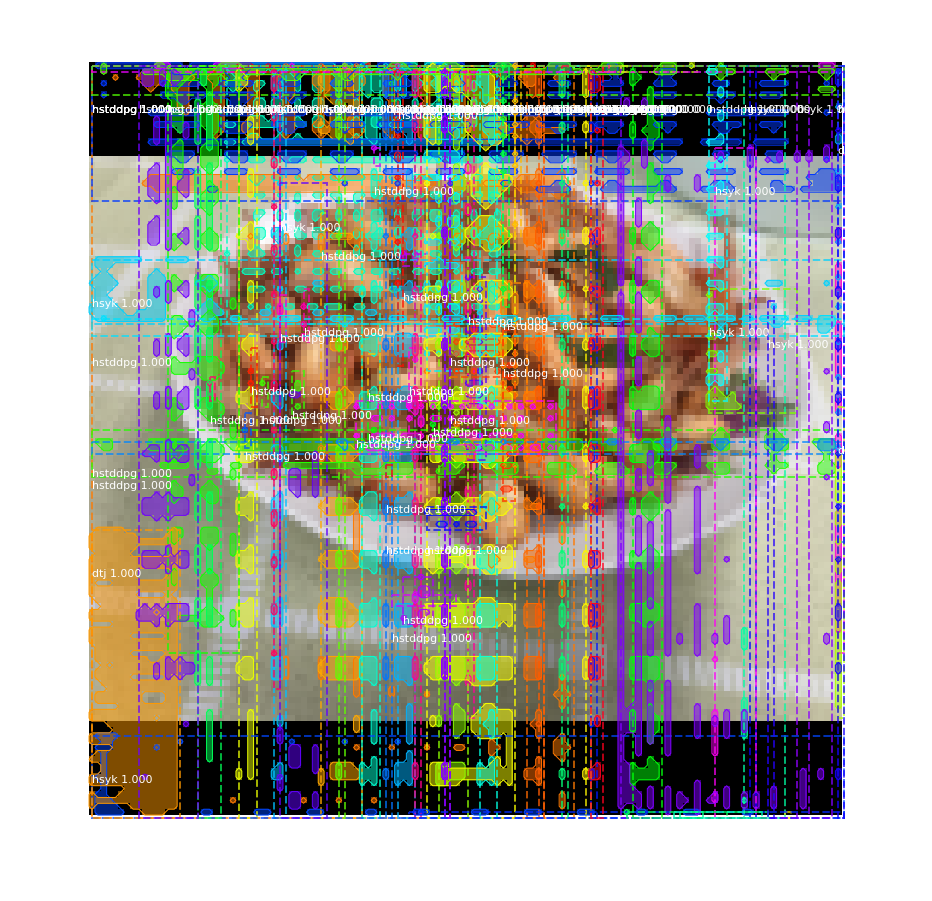

In [7]:


def random_img(display=False):
    # Test on a random image
    image_id = random.choice(dataset_val.image_ids)
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = \
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)

    if display:
        log("original_image", original_image)
        log("image_meta", image_meta)
        log("gt_class_id", gt_class_id)
        log("gt_bbox", gt_bbox)
        log("gt_mask", gt_mask)
        visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                                    dataset_train.class_names, figsize=(8, 8))
    return original_image


def detect(model, img):
    # Get path to saved weights
    # Either set a specific path or find last trained weights
    # model_path = os.path.join(ROOT_DIR, ".h5 file name here")
    results = model.detect([img], verbose=1)
    r = results[0]
    visualize.display_instances(
        img, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names,
        r['scores'])


# Test for a single random image
detect(model, random_img())


In [8]:


def eval(model):
    # Compute VOC-Style mAP @ IoU=0.5
    # Running on 10 images. Increase for better accuracy.
    image_ids = np.random.choice(dataset_val.image_ids, 10)
    APs = []
    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask = \
            modellib.load_image_gt(dataset_val, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(
            modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        AP, precisions, recalls, overlaps = \
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)

    print("mAP: ", np.mean(APs))


eval(model)


mAP:  0.0
